# 04: Architecture Search (bf16)

**Question:** Which model architecture gives us the best combination of training speed and interesting dynamics?

We test three candidates at their predicted optimal batch sizes (from the work constant in 03):

| Architecture | Layers | Hidden | Heads | FFN | Params | Batch | Tokens/Step |
|--------------|--------|--------|-------|-----|--------|-------|-------------|
| Lean | 2 | 64 | 1 | 128 | ~330K | 32 | 4,096 |
| Balanced | 3 | 96 | 2 | 192 | ~618K | 16 | 2,048 |
| Rich | 4 | 128 | 2 | 256 | ~1.05M | 8 | 1,024 |

Each architecture operates at roughly the same "work per step" (~1.27B), so we expect similar frame rates. The question is: which one learns interesting things?

**Note:** We train in bfloat16 to match Qwen 3 4B's training regime.

## Parameters

In [ ]:
# === Parameters ===

# Paths
DATA_DIR = "data"
TOKENIZER_PATH = f"{DATA_DIR}/tokenizer.json"
TOKENS_PATH = f"{DATA_DIR}/model_corpus_tokens.safetensors"

# Architectures to test (with predicted optimal batch sizes)
ARCHITECTURES = {
    'Lean': {
        'n_layers': 2,
        'd_model': 64,
        'n_heads': 1,
        'd_ff': 128,
        'batch_size': 32,
    },
    'Balanced': {
        'n_layers': 3,
        'd_model': 96,
        'n_heads': 2,
        'd_ff': 192,
        'batch_size': 16,
    },
    'Rich': {
        'n_layers': 4,
        'd_model': 128,
        'n_heads': 2,
        'd_ff': 256,
        'batch_size': 8,
    },
}

# Fixed across all architectures
SEQ_LEN = 128
DROPOUT = 0.0

# Training
TRAINING_STEPS = 1000  # Enough to see learning dynamics
LEARNING_RATE = 1e-3
LOG_EVERY = 50  # Log metrics every N steps

# Precision: bf16 to match Qwen 3 4B training regime
import torch
MODEL_DTYPE = torch.bfloat16

# Reproducibility
RANDOM_SEED = 42

## Imports & Device

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from safetensors.torch import load_file
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tokenizers import Tokenizer
import time
from tqdm.auto import tqdm

torch.manual_seed(RANDOM_SEED)

# Device detection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

## Load Tokenizer & Corpus

In [ ]:
# Load tokenizer
tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
vocab_size = tokenizer.get_vocab_size()
print(f"✓ Loaded tokenizer: {vocab_size:,} tokens")

# Load cached tokenized corpus (fast!)
print(f"Loading cached tokens from {TOKENS_PATH}...")
tokens_data = load_file(TOKENS_PATH)
all_tokens = tokens_data["tokens"].to(torch.long)
print(f"✓ Corpus: {len(all_tokens):,} tokens")

## Dataset

In [14]:
class TokenDataset(Dataset):
    """Simple dataset that returns random chunks of tokens."""
    
    def __init__(self, tokens: torch.Tensor, seq_len: int, num_samples: int = 100_000):
        self.tokens = tokens
        self.seq_len = seq_len
        self.num_samples = num_samples
        max_start = len(tokens) - seq_len - 1
        self.starts = torch.randint(0, max_start, (num_samples,))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start = self.starts[idx]
        chunk = self.tokens[start:start + self.seq_len + 1]
        return chunk[:-1], chunk[1:]

dataset = TokenDataset(all_tokens, SEQ_LEN)
print(f"✓ Dataset ready: {len(dataset):,} samples")

✓ Dataset ready: 100,000 samples


## Model Definition

In [15]:
class GPT(nn.Module):
    """Minimal GPT for architecture search."""
    
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, seq_len, dropout=0.0):
        super().__init__()
        
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)
        
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=n_heads,
                dim_feedforward=d_ff,
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            )
            for _ in range(n_layers)
        ])
        
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.head.weight = self.tok_emb.weight  # Weight tying
        
        self.seq_len = seq_len
        self.d_model = d_model
        self.register_buffer('causal_mask', None)
    
    def forward(self, x):
        B, T = x.shape
        
        if self.causal_mask is None or self.causal_mask.shape[0] != T:
            self.causal_mask = torch.triu(
                torch.ones(T, T, device=x.device, dtype=torch.bool),
                diagonal=1
            )
        
        pos = torch.arange(T, device=x.device)
        h = self.tok_emb(x) + self.pos_emb(pos)
        
        for layer in self.layers:
            h = layer(h, src_mask=self.causal_mask, is_causal=True)
        
        h = self.ln_f(h)
        return self.head(h)

print("✓ Model class defined")

✓ Model class defined


## Training Function

In [16]:
def train_model(name, config, dataset, vocab_size, device, 
                training_steps, log_every, lr=1e-3):
    """
    Train a model and collect metrics.
    
    Returns: dict with training history and timing info
    """
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"{'='*60}")
    
    # Create model in bf16
    model = GPT(
        vocab_size=vocab_size,
        d_model=config['d_model'],
        n_heads=config['n_heads'],
        n_layers=config['n_layers'],
        d_ff=config['d_ff'],
        seq_len=SEQ_LEN,
        dropout=DROPOUT
    ).to(device).to(MODEL_DTYPE)
    
    n_params = sum(p.numel() for p in model.parameters())
    batch_size = config['batch_size']
    tokens_per_step = batch_size * SEQ_LEN
    
    print(f"  Parameters: {n_params:,} ({MODEL_DTYPE})")
    print(f"  Batch size: {batch_size} (tokens/step: {tokens_per_step:,})")
    
    # Setup training
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    loader_iter = iter(loader)
    
    # Metrics to track
    history = {
        'step': [],
        'loss': [],
        'tokens_seen': [],
    }
    
    model.train()
    total_tokens = 0
    
    # Training loop
    start_time = time.perf_counter()
    
    pbar = tqdm(range(training_steps), desc=name)
    for step in pbar:
        # Get batch
        try:
            x, y = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            x, y = next(loader_iter)
        
        x, y = x.to(device), y.to(device)
        
        # Forward + backward
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()
        optimizer.step()
        
        total_tokens += tokens_per_step
        
        # Log metrics
        if step % log_every == 0 or step == training_steps - 1:
            history['step'].append(step)
            history['loss'].append(loss.item())
            history['tokens_seen'].append(total_tokens)
            pbar.set_postfix(loss=f"{loss.item():.3f}")
    
    # Sync and measure time
    if device == 'mps':
        torch.mps.synchronize()
    elif device == 'cuda':
        torch.cuda.synchronize()
    
    elapsed = time.perf_counter() - start_time
    
    # Summary stats
    results = {
        'name': name,
        'config': config,
        'n_params': n_params,
        'history': history,
        'elapsed_sec': elapsed,
        'steps_per_sec': training_steps / elapsed,
        'tokens_per_sec': total_tokens / elapsed,
        'final_loss': history['loss'][-1],
        'initial_loss': history['loss'][0],
    }
    
    print(f"\n  Time: {elapsed:.1f}s ({results['steps_per_sec']:.1f} steps/s)")
    print(f"  Throughput: {results['tokens_per_sec']/1000:.1f}k tokens/s")
    print(f"  Loss: {results['initial_loss']:.3f} → {results['final_loss']:.3f}")
    
    return results

print(f"✓ Training function defined (dtype: {MODEL_DTYPE})")

✓ Training function defined (dtype: torch.bfloat16)


## Run Architecture Search

In [17]:
print("="*70)
print("ARCHITECTURE SEARCH")
print("="*70)
print(f"Training each architecture for {TRAINING_STEPS:,} steps")
print(f"Work constant target: ~1.27B (each should have similar frame rate)")

all_results = {}

for name, config in ARCHITECTURES.items():
    # Clear cache between runs
    if device == 'mps':
        torch.mps.empty_cache()
    elif device == 'cuda':
        torch.cuda.empty_cache()
    
    # Reset random state for fair comparison
    torch.manual_seed(RANDOM_SEED)
    
    results = train_model(
        name, config, dataset, vocab_size, device,
        TRAINING_STEPS, LOG_EVERY, LEARNING_RATE
    )
    all_results[name] = results

print("\n" + "="*70)
print("✓ Architecture search complete")
print("="*70)

ARCHITECTURE SEARCH
Training each architecture for 1,000 steps
Work constant target: ~1.27B (each should have similar frame rate)

Training: Lean
  Parameters: 330,496 (torch.bfloat16)
  Batch size: 32 (tokens/step: 4,096)


Lean:   0%|          | 0/1000 [00:00<?, ?it/s]


  Time: 8.4s (119.5 steps/s)
  Throughput: 489.7k tokens/s
  Loss: 44.000 → 8.188

Training: Balanced
  Parameters: 619,680 (torch.bfloat16)
  Batch size: 16 (tokens/step: 2,048)


Balanced:   0%|          | 0/1000 [00:00<?, ?it/s]


  Time: 8.3s (120.5 steps/s)
  Throughput: 246.9k tokens/s
  Loss: 65.500 → 8.062

Training: Rich
  Parameters: 1,057,024 (torch.bfloat16)
  Batch size: 8 (tokens/step: 1,024)


Rich:   0%|          | 0/1000 [00:00<?, ?it/s]


  Time: 9.8s (101.8 steps/s)
  Throughput: 104.2k tokens/s
  Loss: 85.500 → 8.375

✓ Architecture search complete


## Results Comparison

In [18]:
import pandas as pd

# Build comparison table
rows = []
for name, r in all_results.items():
    rows.append({
        'Architecture': name,
        'Params': r['n_params'],
        'Batch': r['config']['batch_size'],
        'Steps/sec': r['steps_per_sec'],
        'Tokens/sec': r['tokens_per_sec'],
        'Initial Loss': r['initial_loss'],
        'Final Loss': r['final_loss'],
        'Loss Drop': r['initial_loss'] - r['final_loss'],
    })

df = pd.DataFrame(rows)

print("Architecture Comparison")
print("="*80)
print(df.to_string(index=False, formatters={
    'Params': lambda x: f"{x:,}",
    'Steps/sec': lambda x: f"{x:.1f}",
    'Tokens/sec': lambda x: f"{x/1000:.1f}k",
    'Initial Loss': lambda x: f"{x:.3f}",
    'Final Loss': lambda x: f"{x:.3f}",
    'Loss Drop': lambda x: f"{x:.3f}",
}))

Architecture Comparison
Architecture    Params  Batch Steps/sec Tokens/sec Initial Loss Final Loss Loss Drop
        Lean   330,496     32     119.5     489.7k       44.000      8.188    35.812
    Balanced   619,680     16     120.5     246.9k       65.500      8.062    57.438
        Rich 1,057,024      8     101.8     104.2k       85.500      8.375    77.125


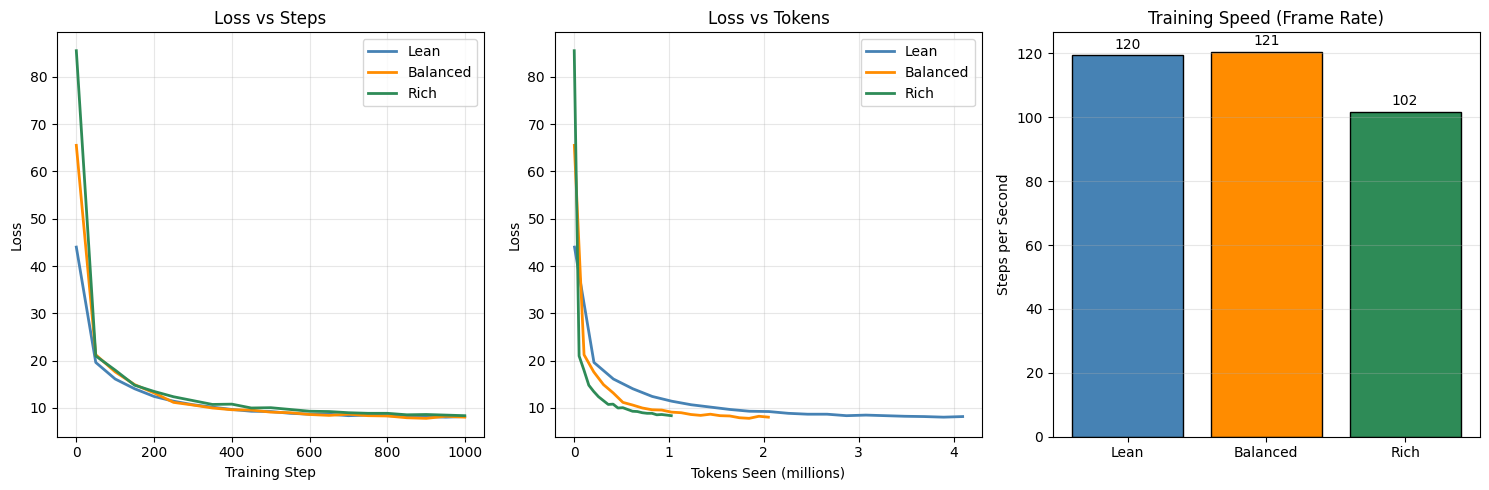

✓ Saved: architecture_search@200.png, architecture_search@72.png


In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = {'Lean': 'steelblue', 'Balanced': 'darkorange', 'Rich': 'seagreen'}

# 1. Loss curves (by step)
ax1 = axes[0]
for name, r in all_results.items():
    ax1.plot(r['history']['step'], r['history']['loss'], 
             label=name, color=colors[name], linewidth=2)
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs Steps')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Loss curves (by tokens seen)
ax2 = axes[1]
for name, r in all_results.items():
    tokens_M = [t/1e6 for t in r['history']['tokens_seen']]
    ax2.plot(tokens_M, r['history']['loss'],
             label=name, color=colors[name], linewidth=2)
ax2.set_xlabel('Tokens Seen (millions)')
ax2.set_ylabel('Loss')
ax2.set_title('Loss vs Tokens')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Speed comparison
ax3 = axes[2]
names = list(all_results.keys())
steps_per_sec = [all_results[n]['steps_per_sec'] for n in names]
bar_colors = [colors[n] for n in names]
bars = ax3.bar(names, steps_per_sec, color=bar_colors, edgecolor='black')
ax3.set_ylabel('Steps per Second')
ax3.set_title('Training Speed (Frame Rate)')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, steps_per_sec):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{val:.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('architecture_search@200.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.savefig('architecture_search@72.png', dpi=72, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: architecture_search@200.png, architecture_search@72.png")

## Summary

In [20]:
print("\n" + "="*70)
print("ARCHITECTURE SEARCH COMPLETE")
print("="*70)

print(f"\nWork constant validation:")
print(f"  (Should all be ~1.27B if our prediction holds)")
for name, r in all_results.items():
    work = r['n_params'] * r['config']['batch_size'] * SEQ_LEN
    print(f"  {name}: {work/1e9:.2f}B")

print(f"\nFrame rate comparison:")
print(f"  (Should be similar if work constant holds)")
for name, r in all_results.items():
    print(f"  {name}: {r['steps_per_sec']:.1f} steps/sec")

print(f"\nLearning comparison:")
for name, r in all_results.items():
    drop = r['initial_loss'] - r['final_loss']
    print(f"  {name}: {r['initial_loss']:.3f} → {r['final_loss']:.3f} (Δ={drop:.3f})")

# Find best by different criteria
best_speed = max(all_results.keys(), key=lambda n: all_results[n]['steps_per_sec'])
best_loss = min(all_results.keys(), key=lambda n: all_results[n]['final_loss'])
best_learning = max(all_results.keys(), key=lambda n: all_results[n]['initial_loss'] - all_results[n]['final_loss'])

print(f"\nBest by criterion:")
print(f"  Fastest (steps/sec): {best_speed}")
print(f"  Lowest final loss: {best_loss}")
print(f"  Most learning (Δloss): {best_learning}")

print("\n" + "="*70)


ARCHITECTURE SEARCH COMPLETE

Work constant validation:
  (Should all be ~1.27B if our prediction holds)
  Lean: 1.35B
  Balanced: 1.27B
  Rich: 1.08B

Frame rate comparison:
  (Should be similar if work constant holds)
  Lean: 119.5 steps/sec
  Balanced: 120.5 steps/sec
  Rich: 101.8 steps/sec

Learning comparison:
  Lean: 44.000 → 8.188 (Δ=35.812)
  Balanced: 65.500 → 8.062 (Δ=57.438)
  Rich: 85.500 → 8.375 (Δ=77.125)

Best by criterion:
  Fastest (steps/sec): Balanced
  Lowest final loss: Balanced
  Most learning (Δloss): Rich

